In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [6]:
# Define named tuple for PCA results
PcaPack = namedtuple("PCAPack", ["X", "U", "V", "mu", "K", 
    "n_samples", "n_features", "signals", "sample_aligns", "feature_aligns"])


In [19]:
class MultiModalityPCA:
    """
    Performs PCA on multiple modality matrices and analyzes residual spectra.

    Methods
    -------
    fit(X_list, K_list, plot_residual=False):
        Computes PCA for each modality and optionally plots residual spectrum.
    check_residual_spectrum():
        Plots residual singular value spectrum for each modality.
    generate_synthetic_data(n_samples, p_list, K_list):
        Generates synthetic data using:
            X_k = (1/n) U_k D_k V_k^T + Z
        ensuring D_k > lambda^{-1/4}.

    Attributes
    ----------
    pca_results : dict
        Stores PCA results for each modality.
    """

    def __init__(self):
        self.pca_results = {}

    def fit(self, X_list, K_list, plot_residual=False):
        """
        Perform PCA for multiple modality matrices.

        Parameters
        ----------
        X_list : list of ndarray
            List of m data matrices X_k of shape (n_samples, p_k).
        K_list : list of int
            List of m values specifying the number of principal components per modality.
        plot_residual : bool, optional
            Whether to plot the residual spectrum (default is False).
        """
        if len(X_list) != len(K_list):
            raise ValueError("Mismatch: Number of modalities and K values must be the same.")

        for k, (X_k, K_k) in enumerate(zip(X_list, K_list)):
            print(f"\nPerforming PCA for Modality {k} (Shape: {X_k.shape}, K={K_k})")
            self.pca_results[k] = self._get_pca(X_k, K_k, k)

            if plot_residual:
                self._plot_residual_spectrum(k)

    def _get_pca(self, X, K, k):
        """
        Perform PCA on a given modality.

        Parameters
        ----------
        X : ndarray (n_samples, n_features)
            Data matrix.
        K : int
            Number of principal components.
        k : int
            Modality index.

        Returns
        -------
        PcaPack : namedtuple
            Contains PCA components, singular values, and alignments.
        """
        if K == 0:
            raise ValueError("# Principal Components (K) cannot be zero.")

        n_samples, n_features = X.shape
        U, Lambdas, Vh = np.linalg.svd(X, full_matrices=False)

        # Extract top-K components
        U_K = U[:, :K]
        Lambda_K = np.diag(Lambdas[:K])
        V_K = Vh[:K, :]

        # Compute residual matrix (X with top-K removed)
        X_residual = X - U_K @ Lambda_K @ V_K
        _, residual_singular_values, _ = np.linalg.svd(X_residual, full_matrices=False)

        # Compute aspect ratio
        aspect_ratio = n_features / n_samples
        print(f"[Modality {k}] Aspect ratio: {aspect_ratio:.4f}")

        # Compute estimated signal strength
        greek_lambda = Lambdas[:K] / np.sqrt(aspect_ratio)

        # Compute alignments
        sample_align = np.sqrt(np.maximum(1 - (1 + greek_lambda**2) / (greek_lambda**2 * (aspect_ratio * greek_lambda**2 + 1)), 0))
        feature_align = np.sqrt(np.maximum(1 - (1 + aspect_ratio * greek_lambda**2) / (aspect_ratio * greek_lambda**2 * (greek_lambda**2 + 1)), 0))

        return PcaPack(X=X, U=U_K, V=V_K.T, mu=residual_singular_values, 
                       n_samples=n_samples, n_features=n_features,
                       K=K, signals=greek_lambda, sample_aligns=sample_align, 
                       feature_aligns=feature_align)

    def check_residual_spectrum(self, to_show=False, to_save=False, save_path="./residual_spectrum.pdf"):
        """
        Plot residual singular values and compare with Marčenko-Pastur (MP) law.

        Parameters
        ----------
        to_show : bool
            Display the plot.
        to_save : bool
            Save the plot.
        save_path : str
            File path to save.
        """
        for k in self.pca_results.keys():
            self._plot_residual_spectrum(k, to_show, to_save, save_path)

    def _plot_residual_spectrum(self, modality_idx, to_show=False, to_save=False, save_path="./residual_spectrum.pdf"):
        """
        Helper function to plot residual spectrum for a single modality.

        Parameters
        ----------
        modality_idx : int
            Index of the modality.
        to_show : bool
            Display the plot.
        to_save : bool
            Save the plot.
        save_path : str
            File path to save.
        """
        pca_pack = self.pca_results[modality_idx]
        mu = pca_pack.mu
        n_samples = pca_pack.n_samples
        n_features = pca_pack.n_features
        shorter_side = min(n_samples, n_features)
        
        fig, ax = plt.subplots()
        ax.hist(mu[:shorter_side], density=True, bins=50, label="Sample singular values")
        x = np.linspace(mu.min()-0.1, mu.max(), num=50)
        
        aspect_ratio = n_features / n_samples
        scaler = max(aspect_ratio, 1)

        ax.plot(x, scaler * np.array(self._sqrtMPlaw(x, n_samples, n_features)), 
                label="MP law prediction")
        
        ax.legend()
        ax.set_title(f"Residual Singular Values (Modality {modality_idx})")
        
        if to_save:
            fig.savefig(save_path.replace(".pdf", f"_modality{modality_idx}.pdf"))
        if to_show:
            plt.show()
        else:
            plt.close(fig)

    def generate_synthetic_data(self, n_samples, p_list, K_list):
        """
        Generate synthetic data for multiple modalities.

        Parameters
        ----------
        n_samples : int
            Number of samples.
        p_list : list of int
            List of feature dimensions for each modality.
        K_list : list of int
            List of principal component counts per modality.

        Returns
        -------
        X_list : list of ndarray
            Generated data matrices.
        """
        X_list = []
        for k, p_k in enumerate(p_list):
            aspect_ratio = p_k / n_samples
            lambda_threshold = aspect_ratio ** (-1/4)  # Minimum threshold for D_k diagonal

            U_k = np.random.randn(n_samples, K_list[k])
            V_k = np.random.randn(p_k, K_list[k])
            
            # Generate diagonal D_k ensuring values > lambda_threshold
            D_k = np.diag(lambda_threshold + 10.0 + np.random.rand(K_list[k]) * 4)  # Further increased values

            # Generate X_k
            signal = (1/n_samples) * U_k @ D_k @ V_k.T
            noise = np.random.randn(n_samples, p_k) / np.sqrt(n_samples)
            X_k = signal + noise
            X_list.append(X_k)

        return X_list

    def _sqrtmplaw(self, x, n, p):
        aspect_ratio = p / n
        lambda_plus = (1 + np.sqrt(aspect_ratio))**2
        lambda_minus = (1 - np.sqrt(aspect_ratio))**2
        if x**2 < lambda_minus or x**2 > lambda_plus:
            return 0
        return 1 / (np.pi * aspect_ratio * x) * np.sqrt((lambda_plus - x**2) * (x**2 - lambda_minus))

    def _sqrtMPlaw(self, arr, n, p):
        return [self._sqrtmplaw(x, n, p) for x in arr]


--- Running Multi-Modality PCA ---

Performing PCA for Modality 0 (Shape: (1000, 500), K=5)
[Modality 0] Aspect ratio: 0.5000

Performing PCA for Modality 1 (Shape: (1000, 300), K=3)
[Modality 1] Aspect ratio: 0.3000

Performing PCA for Modality 2 (Shape: (1000, 400), K=4)
[Modality 2] Aspect ratio: 0.4000


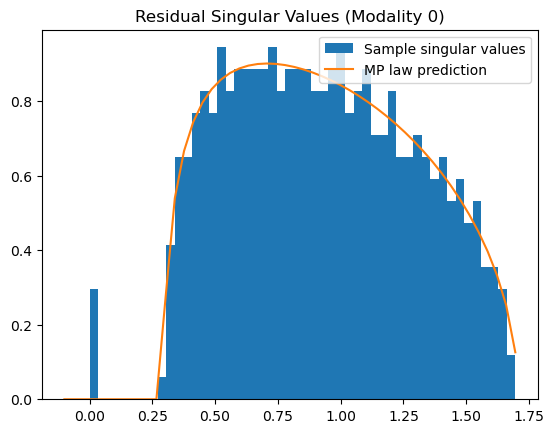

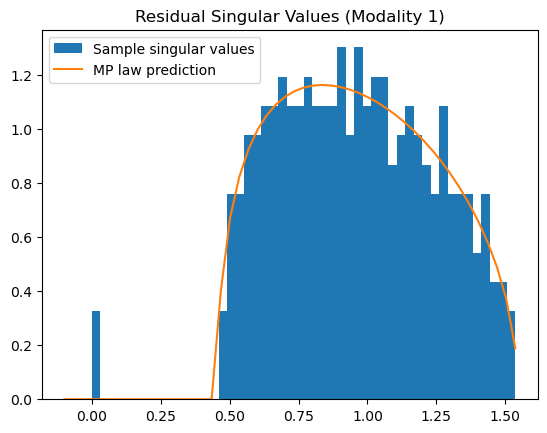

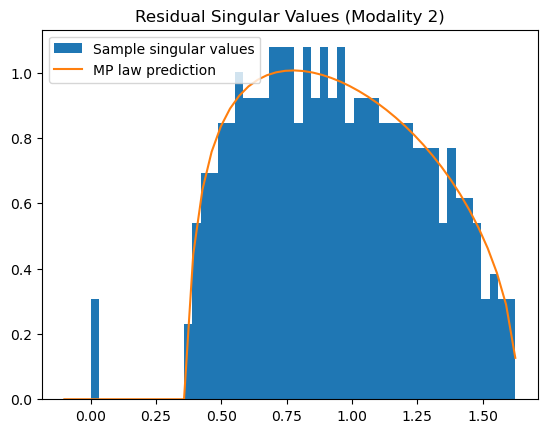

In [21]:
# ------------------------------
# Example Usage
# ------------------------------
if __name__ == "__main__":
    # Initialize PCA model
    pca_model = MultiModalityPCA()

    # Define parameters
    n_samples = 1000  # Number of samples
    p_list = [500, 300, 400]  # Different feature dimensions per modality
    K_list = [5, 3, 4]  # Number of principal components per modality

    # Generate synthetic data
    X_list = pca_model.generate_synthetic_data(n_samples, p_list, K_list)

    # Perform PCA (enable `plot_residual=True` if residual spectrum should be plotted during fitting)
    print("\n--- Running Multi-Modality PCA ---")
    pca_model.fit(X_list, K_list, plot_residual=False)  # Set to True if you want to see residual plots immediately

    # Check residual spectrum separately (only if desired)
    pca_model.check_residual_spectrum(to_show=True)  # Can be disabled by setting to_show=False